# Conformal Classification: first steps

This tutorial should get you started doing **Conformal Classification** with the [`cods`](https://github.com/leoandeol/cods) library.

For more information on the methods implemented in CODS, see the papers:
- [Vovk et al. 2005: Algorithmic Learning in a Random World](https://link.springer.com/book/10.1007/978-3-031-06649-8)
- [Angelopoulos et al. 2021: Conformal Prediction: A Gentle Introduction](https://www.nowpublishers.com/article/Details/MAL-101)
- [Shafer et al. 2008: A Tutorial on Conformal Prediction](https://www.jmlr.org/papers/v9/shafer08a.html)
- [Angelopoulos et al. 2022: Conformal Risk Control](https://arxiv.org/abs/2208.02814)
- [Park et al. 2020: PAC Confidence Sets for Deep Neural Networks via Calibrated Prediction](https://arxiv.org/abs/2001.00106)
- [Bates et al 2019: Risk Controlling Prediction Sets](https://dl.acm.org/doi/abs/10.1145/3478535)


### Get started
1. Download the ImageNet dataset: 
    - https://cocodataset.org/
2. Download A Classification Model: automatically via Torch Image Models:
    - source: https://github.com/huggingface/pytorch-image-models/

### Contents
What we will be doing:
1. Setup inference [⤵](#Setup-inferences)
    - load predictor pretrained on ImageNet 
    - Split the validation into: calibration & validation dataset
2. Run inferences on these datasets [⤵](#Setup-inferences)
    - Save predictions to disk: faster than re-predict for every test
3. Test Conformal Prediction !

In [1]:
import timm

from cods.classif.data import ImageNetDataset
from cods.classif.models import ClassificationModel

In [2]:
model_name = "resnet34"
pretrained_resnet_34 = timm.create_model(model_name, pretrained=True)
classifier = ClassificationModel(model=pretrained_resnet_34, model_name=model_name)

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [3]:
val_dataset = ImageNetDataset(...)  # path to imagenet validation set
cal_dataset, test_dataset = val_dataset.random_split(lengths=[40000, 10000])

TypeError: stat: path should be string, bytes, os.PathLike or integer, not ellipsis

In [ ]:
cal_preds = classifier.build_predictions(
    cal_dataset,
    dataset_name="imagenet",
    split_name="cal",
    batch_size=512,
    shuffle=False,
)

test_preds = classifier.build_predictions(
    test_dataset,
    dataset_name="imagenet",
    split_name="test",
    batch_size=512,
    shuffle=False,
)

Predictions already exist, loading them...
Predictions already exist, loading them...


In [ ]:
from cods.classif.cp import ClassificationConformalizer

cc = ClassificationConformalizer(method="lac", preprocess="softmax")
quant, scores = cc.calibrate(cal_preds, alpha=0.1, verbose=print)
conf_cls = cc.conformalize(test_preds)
losses, set_sizes = cc.evaluate(test_preds, conf_cls)

Calibrated quantile: 0.9858390688896179
Coverage: 0.9199999570846558, Avg. set size: 2.569999933242798


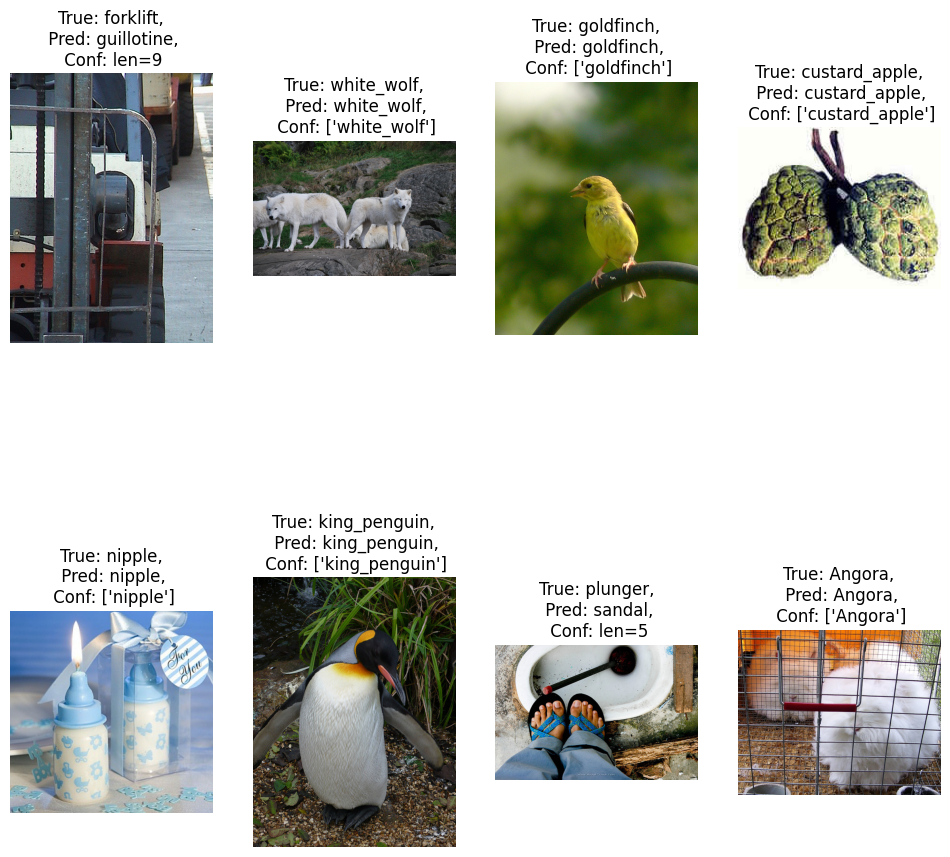

In [ ]:
from cods.classif.visualization import plot_predictions

plot_predictions([1, 2, 3, 4, 5, 6, 7, 8], test_preds, conf_cls)

In [ ]:
from cods.classif.tr import ClassificationToleranceRegion

ctr = ClassificationToleranceRegion(loss="lac", preprocess="softmax")
ctr.calibrate(cal_preds, alpha=0.1, delta=1e-3, verbose=False)
tr_conf_cls = ctr.conformalize(test_preds)
losses, set_sizes = ctr.evaluate(test_preds)

Coverage: 0.9399999976158142, Avg. set size: 4.400000095367432


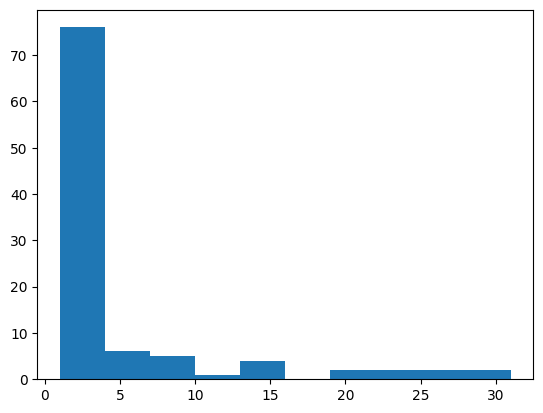

In [ ]:
import matplotlib.pyplot as plt

plt.hist(set_sizes, bins=10)

In [ ]:
from cods.classif.metrics import get_coverage, get_empirical_safety

get_coverage(test_preds, conf_cls)
get_empirical_safety(test_preds, tr_conf_cls, loss="lac")

Coverage:  0.9200000166893005
Empirical safety:  0.9399999976158142
